In [24]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
file_path = '/Users/gali/Desktop/dsmp-2024-group15/Python files/LSTM/SARIMAX_asks.csv'
ask = pd.read_csv(file_path)
del ask['Type']
del ask['adjusted_time_hours']
print(ask)

           Price
0     259.058784
1     257.922733
2     266.827586
3     280.176471
4     283.926437
...          ...
1058  115.226240
1059  115.324496
1060  113.814666
1061  114.353052
1062  114.180948

[1063 rows x 1 columns]


Testing original data:
Apred Statistic: -0.923053
p-value: 0.780286
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
1       -1.136051
2        8.904853
3       13.348884
4        3.749966
5       -5.434691
          ...    
1058     0.001600
1059     0.098256
1060    -1.509830
1061     0.538386
1062    -0.172104
Name: Price, Length: 1062, dtype: float64

Determining the differencing order needed for stationarity:
1       -1.136051
2        8.904853
3       13.348884
4        3.749966
5       -5.434691
          ...    
1058     0.001600
1059     0.098256
1060    -1.509830
1061     0.538386
1062    -0.172104
Name: Price, Length: 1062, dtype: float64

Differencing Order: 1
Apred Statistic: -9.244350
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Series is stationary


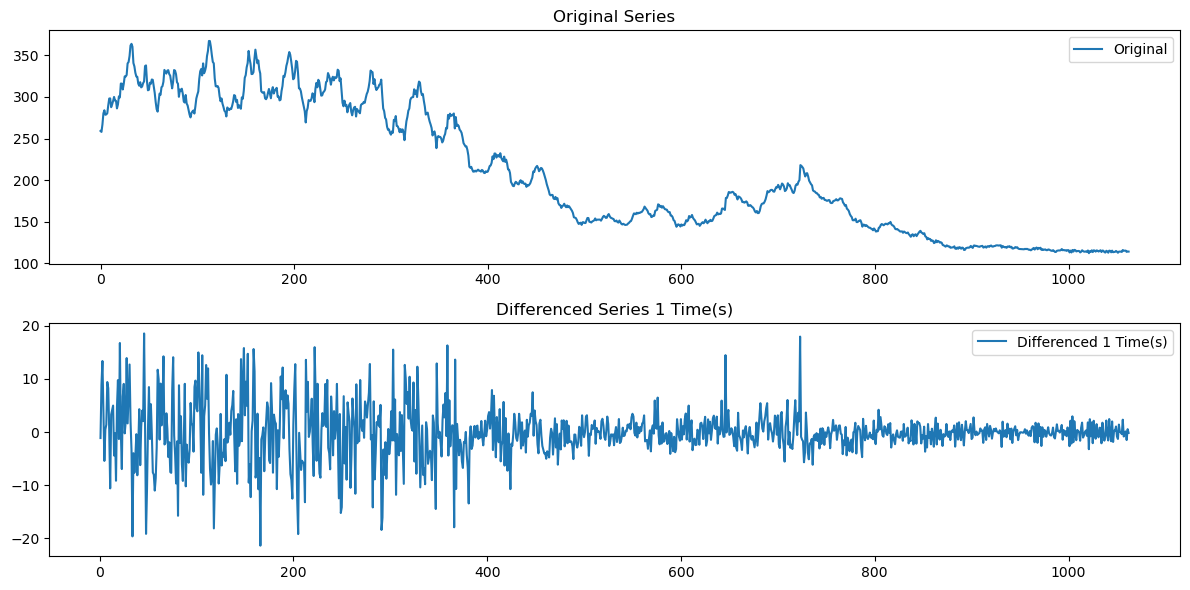

In [25]:
def apred_test(time_series):
    """Perform Apred test and return results"""
    result = adfuller(time_series, autolag='AIC')  # Apred test
    print('Apred Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result

def determine_diff_order(timeseries, max_diff=5):
    """Apply iterative differencing and Apred test to determine the order of differencing"""
    p_value = 1
    diff_order = 1
    while p_value > 0.05 and diff_order <= max_diff:
        diff_series = timeseries.diff(periods=diff_order).dropna()
        print(diff_series)
        print(f"\nDifferencing Order: {diff_order}")
        result = apred_test(diff_series)
        p_value = result[1]
        if p_value < 0.05:
            print("Series is stationary")
            break
        diff_order += 1
    return diff_order

# Check original data's stationarity
print("Testing original data:")
apred_test(ask.Price)
ask_diff = ask.Price.diff().dropna()
print(ask_diff)

# Determine the order of differencing needed
print("\nDetermining the differencing order needed for stationarity:")
order = determine_diff_order(ask.Price)

# Plot original and differenced data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(ask.Price, label='Original')
plt.title('Original Series')
data_points = len(ask.Price)
plt.legend()
# interval_hours = 30
# start_date = ask.index[0]
# end_date = ask.index[-1]
# num_intervals = int(((end_date - start_date).total_seconds() / 3600) // interval_hours)
# for i in range(1, num_intervals + 1):
#     plt.axvline(x=start_date + pd.Timedelta(hours=interval_hours * i), color='gray', linestyle='--')


plt.subplot(212)
plt.plot(ask.Price.diff(periods=order).dropna(), label=f'Differenced {order} Time(s)')
plt.title(f'Differenced Series {order} Time(s)')
plt.legend()

plt.tight_layout()
plt.show()



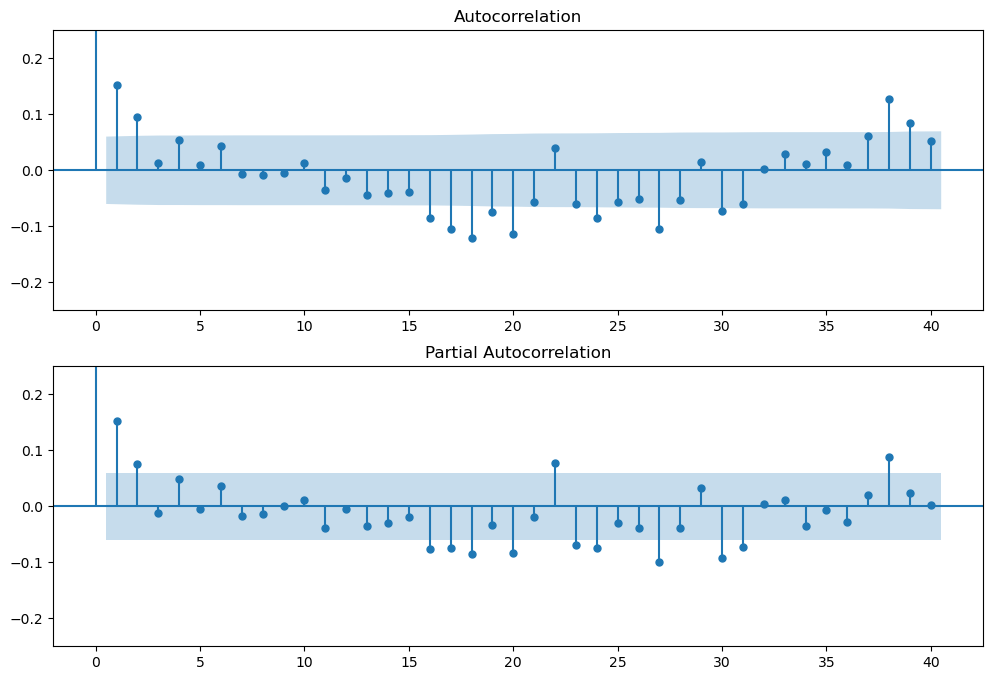

In [27]:
import statsmodels.api as sm
#ask_diff2 = ask_diff.diff().dropna()
#ask_diff3 = ask_diff2.diff().dropna()
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ask_diff,lags=40,ax=ax1)
ax1.set_ylim(-0.25, 0.25)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ask_diff,lags=40,ax=ax2)
ax2.set_ylim(-0.25, 0.25)
plt.savefig('afc_pacf.png')

In [28]:
import itertools
p = d = q = range(0, 2)  
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 17) for x in list(itertools.product(p, d, q))]  

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ask,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print("Best SARIMAX model parameters - AIC:", best_aic)
print("p,d,q:", best_pdq)
print("P,D,Q,Seasonal Period:", best_seasonal_pdq)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81588D+00    |proj g|=  8.88178D-11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.882D-11   6.816D+00
  F =   6.8158817482687795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49405D+00    |proj g|=  9.32353D-02

At iterate    5    f=  6.44871D+00    |proj g|=  3.27499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     13      1     0     0   2.660D-06   6.204D+00
  F =   6.2037871694269207     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.42346D+00    |proj g|=  4.69347D-02

At iterate   10    f=  4.41455D+00    |proj g|=  3.87348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     13      1     0     0   1.491D-06   4.415D+00
  F =   4.4145508142255574     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66012D+00    |proj g|=  1.09440D-02

At iterate    5    f=  4.64893D+00    |proj g|=  1.19026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8      9      1     0     0   6.226D-07   4.649D+00
  F =   4.6489135029249686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  4.36902D+00    |proj g|=  5.88236D-03

At iterate   10    f=  4.36883D+00    |proj g|=  3.21023D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     12      1     0     0   3.210D-06   4.369D+00
  F =   4.3688255983520401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44137D+00    |proj g|=  3.64995D-01


 This problem is unconstrained.



At iterate    5    f=  4.36725D+00    |proj g|=  2.81940D-03

At iterate   10    f=  4.36648D+00    |proj g|=  3.62085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   2.032D-06   4.366D+00
  F =   4.3664800896850720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81588D+00    |proj g|=  1.00118D+00

At iterate    5    f=  6.45082D+00    |proj g|=  7.75474D-03

At iterate   10    f=  6.15322D+00    |proj g|=  5.90557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     18      1     0     0   4.868D-06   6.152D+00
  F =   6.1519702220184875     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.54499D+00    |proj g|=  1.05507D+00

At iterate    5    f=  4.15946D+00    |proj g|=  4.76119D-02

At iterate   10    f=  4.03860D+00    |proj g|=  6.88348D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     14      1     0     0   6.190D-07   4.038D+00
  F =   4.0381835995438875     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34812D+00    |proj g|=  1.22064D-02

At iterate    5    f=  5.81734D+00    |proj g|=  6.65235D-01

At iterate   10    f=  5.35534D+00    |proj g|=  4.07278D-02

At iterate   15    f=  5.34826D+00    |proj g|=  1.07138D-04

At iterate   20    f=  5.34824D+00    |proj g|=  1.27176D-03
  ys=-9.743E-01  -gs= 2.528E-03 BFGS update SKIPPED

At iterate   25    f=  4.54569D+00    |proj g|=  2.90681D-01

At iterate   30    f=  4.16279D+00    |proj g|=  2.91117D-02

At iterate   35    f=  4.13586D+00    |proj g|=  2.50856D-03

At iterate   40    f=  4.13560D+00    |proj g|=  3.05764D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  6.27741D+00    |proj g|=  3.98641D-02

At iterate   10    f=  6.01538D+00    |proj g|=  2.98085D-01
  ys=-2.516E-01  -gs= 7.956E-01 BFGS update SKIPPED

At iterate   15    f=  4.94615D+00    |proj g|=  3.65102D-02

At iterate   20    f=  4.91324D+00    |proj g|=  4.49851D-03

At iterate   25    f=  4.91228D+00    |proj g|=  2.26883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     48      1     1     0   5.834D-06   4.912D+00
  F =   4.9122832493821518     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  4.05287D+00    |proj g|=  6.02867D-02

At iterate   10    f=  3.87571D+00    |proj g|=  2.41978D-02

At iterate   15    f=  3.87335D+00    |proj g|=  4.14340D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   4.143D-06   3.873D+00
  F =   3.8733508558760770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43428D+00    |proj g|=  8.39905D-01


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  4.09065D+00    |proj g|=  3.82260D-02

At iterate   10    f=  3.88747D+00    |proj g|=  6.87905D-02

At iterate   15    f=  3.86745D+00    |proj g|=  1.16014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   1.727D-06   3.867D+00
  F =   3.8674519105351108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98153D+00    |proj g|=  1.96274D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97907D+00    |proj g|=  4.48525D-02

At iterate    5    f=  2.97622D+00    |proj g|=  3.44751D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   3.448D-06   2.976D+00
  F =   2.9762160637900563     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14132D+00    |proj g|=  5.24391D-03

At iterate    5    f=  3.14126D+00    |proj g|=  6.70094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   3.353D-06   3.141D+00
  F =   3.1412588067361074     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97155D+00    |proj g|=  9.16525D-03

At iterate    5    f=  2.97150D+00    |proj g|=  5.94330D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   3.586D-06   2.972D+00
  F =   2.9715029477308854     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07912D+00    |proj g|=  6.57753D-02

At iterate    5    f=  2.95906D+00    |proj g|=  9.15321D-03

At iterate   10    f=  2.95580D+00    |proj g|=  3.40557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   9.892D-06   2.956D+00
  F =   2.9557658520558503     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96858D+00    |proj g|=  2.61545D-02

At iterate    5    f=  2.96810D+00    |proj g|=  1.14254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   9.908D-06   2.968D+00
  F =   2.9681042439814735     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.13186D+00    |proj g|=  1.20556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   4.482D-07   3.132D+00
  F =   3.1318541097390646     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10517D+00    |proj g|=  8.71441D-02

At iterate    5    f=  2.95644D+00    |proj g|=  1.03075D-01

At iterate   10    f=  2.95099D+00    |proj g|=  2.88792D-03

At iterate   15    f=  2.95086D+00    |proj g|=  8.23964D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   2.148D-05   2.951D+00
  F =   2.9508581609825209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.98261D+00    |proj g|=  5.26662D-03

At iterate   20    f=  2.98250D+00    |proj g|=  3.44491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   1.861D-05   2.983D+00
  F =   2.9825012505679473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31727D+00    |proj g|=  7.80796D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.98010D+00    |proj g|=  5.95739D-03

At iterate   10    f=  2.96860D+00    |proj g|=  2.62104D-04

At iterate   15    f=  2.96816D+00    |proj g|=  1.44311D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   1.533D-06   2.968D+00
  F =   2.9681580456430359     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58577D+00    |proj g|=  2.37869D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  2.98334D+00    |proj g|=  1.69860D-03

At iterate   20    f=  2.98276D+00    |proj g|=  7.70895D-03

At iterate   25    f=  2.98241D+00    |proj g|=  1.20084D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     45      1     0     0   4.935D-06   2.982D+00
  F =   2.9824066277706449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29038D+00    |proj g|=  5.93482D-01


 This problem is unconstrained.



At iterate    5    f=  2.99042D+00    |proj g|=  9.48217D-03

At iterate   10    f=  2.98819D+00    |proj g|=  9.73022D-05

At iterate   15    f=  2.98788D+00    |proj g|=  5.70272D-04

At iterate   20    f=  2.98779D+00    |proj g|=  5.32614D-05

At iterate   25    f=  2.98778D+00    |proj g|=  4.74861D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     31      1     0     0   4.004D-07   2.988D+00
  F =   2.9877770684121674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f=  3.13619D+00    |proj g|=  9.56062D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   7.298D-06   3.136D+00
  F =   3.1361244918672835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22175D+00    |proj g|=  2.18780D-01


 This problem is unconstrained.



At iterate    5    f=  2.99574D+00    |proj g|=  3.36625D-02

At iterate   10    f=  2.96451D+00    |proj g|=  7.81384D-03

At iterate   15    f=  2.96166D+00    |proj g|=  4.29830D-03

At iterate   20    f=  2.96116D+00    |proj g|=  3.86202D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   8.891D-06   2.961D+00
  F =   2.9611270095546338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.97521D+00    |proj g|=  5.35600D-04

At iterate   15    f=  2.97504D+00    |proj g|=  8.81724D-03

At iterate   20    f=  2.97440D+00    |proj g|=  3.12148D-04

At iterate   25    f=  2.97440D+00    |proj g|=  8.72187D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   8.722D-06   2.974D+00
  F =   2.9743985784236244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29155D+00    |proj g|=  2.29158D-02

At iterate    5    f=  3.29130D+00    |proj g|=  2.74897D-03

At iterate   10    f=  3.29129D+00    |proj g|=  3.59575D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   4.564D-06   3.291D+00
  F =   3.2912914748639190     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f=  2.97523D+00    |proj g|=  5.05360D-03

At iterate   20    f=  2.97517D+00    |proj g|=  2.01619D-03

At iterate   25    f=  2.97480D+00    |proj g|=  1.36297D-02

At iterate   30    f=  2.97437D+00    |proj g|=  7.64355D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     47      1     0     0   8.815D-06   2.974D+00
  F =   2.9743724447130826     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  2.97793D+00    |proj g|=  5.46266D-04

At iterate   15    f=  2.97792D+00    |proj g|=  9.58145D-04

At iterate   20    f=  2.97783D+00    |proj g|=  5.41049D-03

At iterate   25    f=  2.97771D+00    |proj g|=  4.34963D-04

At iterate   30    f=  2.97770D+00    |proj g|=  5.30463D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     38      1     0     0   2.329D-06   2.978D+00
  F =   2.9776987626345206     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  3.12429D+00    |proj g|=  2.38451D-03

At iterate   10    f=  3.12405D+00    |proj g|=  5.89021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   2.181D-06   3.124D+00
  F =   3.1240489091976351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20330D+00    |proj g|=  1.96419D-01


 This problem is unconstrained.



At iterate    5    f=  3.04637D+00    |proj g|=  1.23339D-01

At iterate   10    f=  2.97833D+00    |proj g|=  2.40298D-02

At iterate   15    f=  2.95476D+00    |proj g|=  1.29505D-02

At iterate   20    f=  2.95297D+00    |proj g|=  1.58897D-03

At iterate   25    f=  2.95263D+00    |proj g|=  3.96141D-04

At iterate   30    f=  2.95262D+00    |proj g|=  1.47327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     33      1     0     0   1.473D-05   2.953D+00
  F =   2.9526244964413113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07578D+00    |proj g|=  6.58909D-02

At iterate    5    f=  2.95721D+00    |proj g|=  7.87052D-03

At iterate   10    f=  2.95388D+00    |proj g|=  2.10278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   1.128D-06   2.954D+00
  F =   2.9538591530787905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.96752D+00    |proj g|=  1.63227D-02

At iterate   10    f=  2.96674D+00    |proj g|=  1.52304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   5.087D-06   2.967D+00
  F =   2.9667340624696883     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15870D+00    |proj g|=  5.38115D-02


 This problem is unconstrained.



At iterate    5    f=  3.13011D+00    |proj g|=  2.56439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.878D-06   3.130D+00
  F =   3.1300970138793125     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10240D+00    |proj g|=  8.64621D-02


 This problem is unconstrained.



At iterate    5    f=  2.94968D+00    |proj g|=  1.03362D-02

At iterate   10    f=  2.94941D+00    |proj g|=  3.87221D-03

At iterate   15    f=  2.94937D+00    |proj g|=  1.11076D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     16      1     0     0   1.111D-06   2.949D+00
  F =   2.9493714555453230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96725D+00    |proj g|=  6.93247D-03

At iterate    5    f=  2.96719D+00    |proj g|=  1.70241D-03

At iterate   10    f=  2.96716D+00    |proj g|=  6.88791D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   6.888D-06   2.967D+00
  F =   2.9671598166469093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06990D+00    |proj g|=  6.57292D-02

At iterate    5    f=  2.95412D+00    |proj g|=  6.77760D-03

At iterate   10    f=  2.95103D+00    |proj g|=  9.22059D-04

At iterate   15    f=  2.95101D+00    |proj g|=  3.97060D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   3.971D-07   2.951D+00
  F =   2.9510053166873127     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.96539D+00    |proj g|=  1.44048D-02

At iterate   10    f=  2.96457D+00    |proj g|=  1.62238D-03

At iterate   15    f=  2.96456D+00    |proj g|=  9.00547D-04

At iterate   20    f=  2.96455D+00    |proj g|=  2.41287D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   2.413D-06   2.965D+00
  F =   2.9645532846146168     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15373D+00    |proj g|=  4.22846D-02

At iterate    5    f=  3.12696D+00    |proj g|=  2.04326D-03

At iterate   10    f=  3.12691D+00    |proj g|=  3.00440D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   3.009D-06   3.127D+00
  F =   3.1269104906667331     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  2.94937D+00    |proj g|=  3.64382D-02

At iterate   10    f=  2.94705D+00    |proj g|=  5.62577D-03

At iterate   15    f=  2.94702D+00    |proj g|=  3.55621D-04

At iterate   20    f=  2.94702D+00    |proj g|=  7.13740D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   7.137D-07   2.947D+00
  F =   2.9470194452349405     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best SARIMAX model parameters - AIC: 6275.363340569484
p,d,q: (1, 1, 1)
P,D,Q,Seasonal Period: (1, 1, 1, 17)


In [ ]:
# mod1 = SARIMAX(ask_diff, order=(1, 1, 1), seasonal_order=(1, 1, 1, 17))
# results1 = mod1.fit()
# mod2 = SARIMAX(ask_diff, order=(2, 1, 1), seasonal_order=(1, 1, 1, 17))
# results2 = mod2.fit()
# mod3 = SARIMAX(ask_diff, order=(1, 1, 2), seasonal_order=(1, 1, 1, 17))
# results3 = mod3.fit()
# values = [[results1.aic,results1.bic,results1.hqic],
#           [results2.aic,results2.bic,results2.hqic],
#           [results3.aic,results3.bic,results3.hqic]]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10750D+00    |proj g|=  5.42396D-02


 This problem is unconstrained.



At iterate    5    f=  2.95501D+00    |proj g|=  4.00443D-02

At iterate   10    f=  2.94841D+00    |proj g|=  2.08292D-02

At iterate   15    f=  2.94668D+00    |proj g|=  1.20762D-03

At iterate   20    f=  2.94664D+00    |proj g|=  3.42600D-03

At iterate   25    f=  2.94568D+00    |proj g|=  7.79706D-03

At iterate   30    f=  2.94555D+00    |proj g|=  8.89579D-04

At iterate   35    f=  2.94555D+00    |proj g|=  1.79179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     44      1     0     0   9.558D-06   2.946D+00
  F =   2.9455465983353268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

ValueError: operands could not be broadcast together with shapes (0,) (120,) 

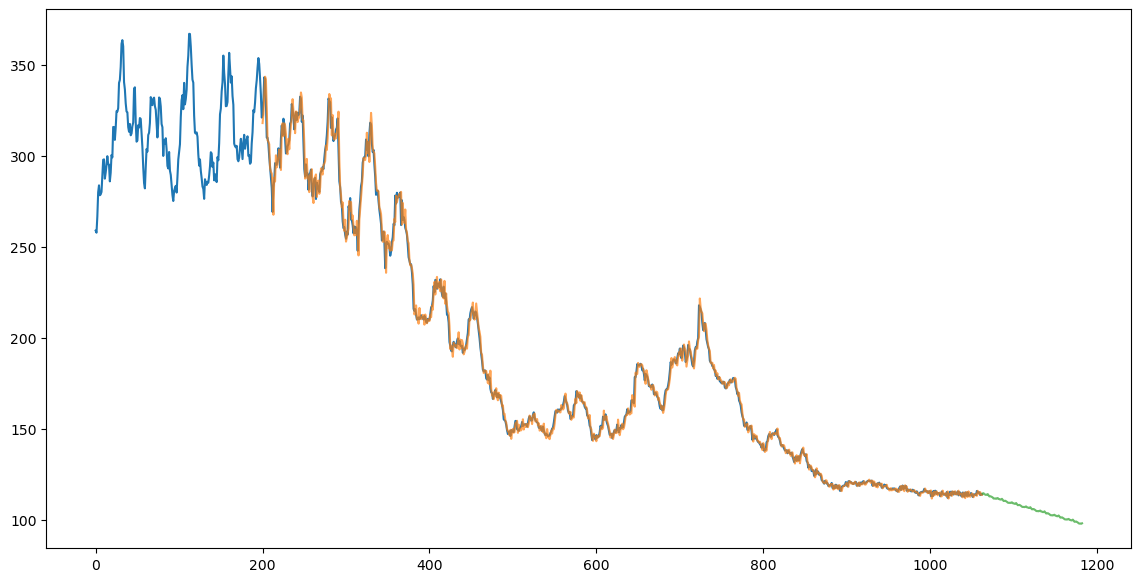

In [31]:

model = SARIMAX(ask.Price, order=(2, 1, 1), seasonal_order=(2, 1, 1, 17))
results = model.fit()
print(results.summary())
prediction = results.get_prediction(start=200, dynamic=False)
predicted_mean = prediction.predicted_mean
forecast = results.get_forecast(steps=120)
forecast_mean = forecast.predicted_mean

start_date = '2025-02-01 00:00:00'

plt.figure(figsize=(14, 7))
#.loc[start_date:]
ask['Price'].plot(label='Observed')
predicted_mean.plot(label='In-sample Prediction', alpha=0.7)
forecast_mean.plot(label='Forecast', alpha=0.7)
plt.fill_between(forecast_mean.loc[start_date:].index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='k', alpha=0.1)
plt.title('SARIMAX Model - Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
#plt.ylim(100, 180)
plt.show()

  

print(results.summary())


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Test RMSE: 6.67


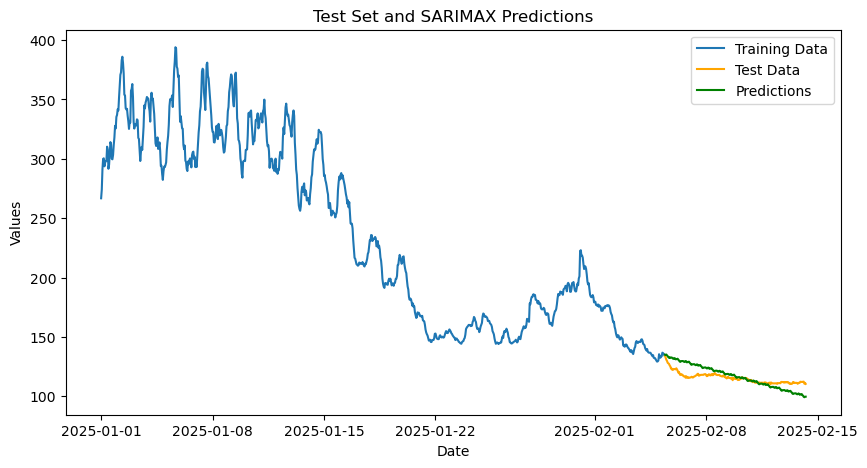

2025-02-05 10:00:00    134.958636
2025-02-05 11:00:00    134.815213
2025-02-05 12:00:00    135.153222
2025-02-05 13:00:00    134.345741
2025-02-05 14:00:00    133.791349
                          ...    
2025-02-14 02:00:00    100.490878
2025-02-14 03:00:00     99.586305
2025-02-14 04:00:00     99.180140
2025-02-14 05:00:00     99.608748
2025-02-14 06:00:00     99.648836
Freq: H, Name: predicted_mean, Length: 213, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

train_data, test_data = train_test_split(ask, test_size=0.2, shuffle=False)

sarimax_model2 = SARIMAX(train_data, order=(2, 1, 1), seasonal_order=(2, 1, 1, 17))
sarimax_result2 = sarimax_model2.fit(disp=False)

predictions2 = sarimax_result2.get_forecast(steps=len(test_data)).predicted_mean

rmse = np.sqrt(mean_squared_error(test_data, predictions2))

print(f'Test RMSE: {rmse:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(test_data.index, predictions2, label='Predictions', color='green')
plt.title('Test Set and SARIMAX Predictions')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
print(predictions2)
predictions2.to_csv('sarima_pred_ask.csv')

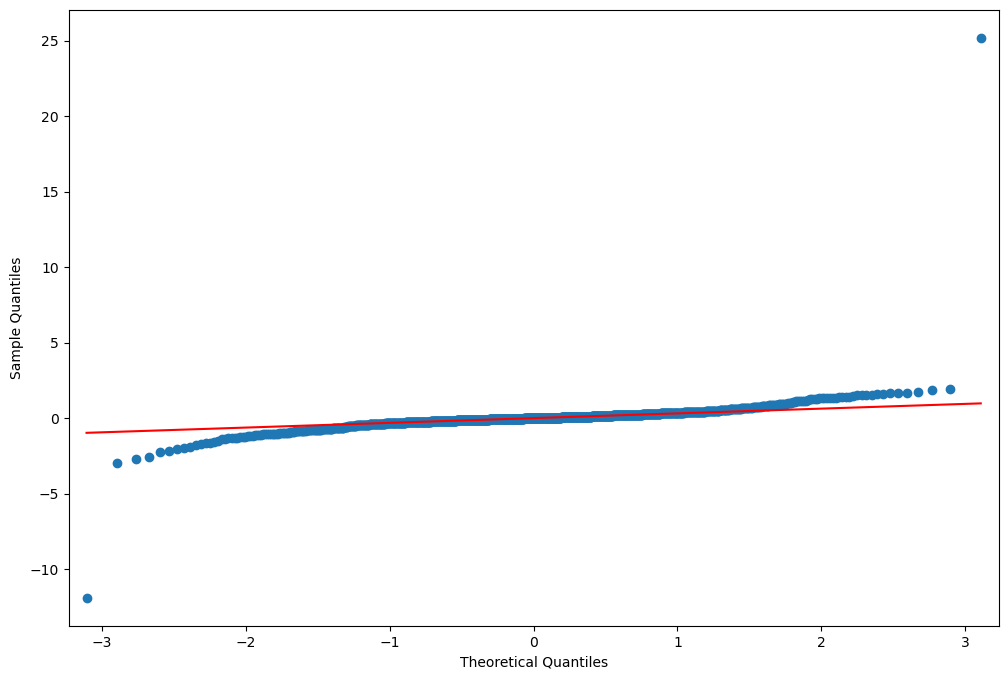

In [10]:
from statsmodels.graphics.api import qqplot
resid = results.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
fig.savefig('sarimaqq.png')

In [30]:
from sklearn.metrics import mean_squared_error
predicted_values = results.get_prediction().predicted_mean

mse = mean_squared_error(ask['Price'], predicted_values)
print('Mean Squared Error (MSE) for in-sample prediction:', mse)

Mean Squared Error (MSE) for in-sample prediction: 106.62475680770139


In [ ]:
#index for TEMA
pred['EMA1'] = pred['Price'].ewm(span=span, adjust=False).mean()
pred['EMA2'] = pred['EMA1'].ewm(span=span, adjust=False).mean()
pred['EMA3'] = pred['EMA2'].ewm(span=span, adjust=False).mean()

#index for P-MA
pred['SMA_50'] = pred['Close'].rolling(window=50).mean()  #50h of SMA

pred['Signal'] = 0
pred['Signal'][pred['Close'] > pred['SMA_50']] = 1  
pred['Signal'][pred['Close'] < pred['SMA_50']] = -1 
pred['Positions'] = pred['Signal'].diff()  # trading strategy e.g. trade when signal changes